In [2]:
%load_ext autoreload
%autoreload 2


import json
import os
import matplotlib.pyplot as plt

import numpy as np
from copy import deepcopy
import random
from math import floor

from ScheduleDistributionSampler import start_times, KLdivergence


In [ ]:
amt_to_script = {
"brush_teeth" : "brushing_teeth",
"bathe_shower" : "showering",
"prepare_eat_breakfast" : "breakfast",
"get_dressed" : "getting_dressed",
"computer_work" : "computer_work",
"prepare_eat_lunch" : "lunch",
"leave_home" : "leave_home",
"come_home" : "come_home",
"play_music" : "playing_music",
"read" : "reading",
"take_medication" : "taking_medication",
"prepare_eat_dinner" : "dinner",
"connect_w_friends" : "socializing",
"listen_to_music" : "listening_to_music",
"clean" : "cleaning",
"clean_kitchen" : "kitchen_cleaning",
"take_out_trash" : "take_out_trash",
"do_laundry" : "laundry",
"use_restroom" : "going_to_the_bathroom",
"vacuum_clean" : "vaccuum_cleaning",
"wash_dishes" : "wash_dishes",
"watch_tv" : "watching_tv",
# "hand_wash_clothes" : "laundry",
"diary_journaling" : "diary_logging",
"wake_up" : "wake_up",
"sleep" : "sleep",
"nap" : "nap"
}

script_to_amt = {v:k for k,v in amt_to_script.items()}

activities = list(script_to_amt.keys())

### Clean up data from AMT

In [ ]:
removed_participants = ['AFER49XXMM4PE', 'A332L3FO6RCY6G', 'A3FKOG3VU5MP0X', 'A3EF9IKIU8IAHY']

corrections = [
('A1KYKDX6XH90OT','dinner',[0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A1KYKDX6XH90OT','breakfast',[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A23KAJRDVCVGOE','dinner',[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
('A23KAJRDVCVGOE','breakfast',[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0]),
('A26M997VYVK0E6','lunch',[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A26M997VYVK0E6','dinner',[0, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A3GWCILDIQLY6U','lunch',[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0]),
('A3GWCILDIQLY6U','dinner',[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
('A1KYKDX6XH90OT','sleep',[-1, 0, 0, 0, 0, 0, -1, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0]),
('A1KYKDX6XH90OT','nap',[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
('A1KYKDX6XH90OT','wake_up',[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0]),
('A23KAJRDVCVGOE','sleep',[0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A23KAJRDVCVGOE','nap',[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('AM4CVEUB9KITP','sleep',[0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0]),
('AM4CVEUB9KITP','nap',[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
('A2P65VCJIAZOYW','sleep',[0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A2P65VCJIAZOYW','nap',[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A1MS6RMVVATCNE','sleep',[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0]),
('A1MS6RMVVATCNE','nap',[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
('A1MS6RMVVATCNE','wake_up',[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0]),
('A2E3V6BKN6ZRFX','sleep',[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0]),
('A2E3V6BKN6ZRFX','nap',[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
('A2E3V6BKN6ZRFX','wake_up',[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0]),
('A3GWCILDIQLY6U','sleep',[0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A3GWCILDIQLY6U','nap',[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A3GWCILDIQLY6U','wake_up',[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0]),
('A1SH1K3O9YE16Y','sleep',[0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A1SH1K3O9YE16Y','nap',[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A1SH1K3O9YE16Y','wake_up',[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0]),
('A22HIX1M4QXZBB','sleep',[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A22HIX1M4QXZBB','wake_up',[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('AQ5KOKZQSZU0B','sleep',[-1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('AQ5KOKZQSZU0BB','wake_up',[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A8UJNIY9R8S7W','sleep',[-1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A8UJNIY9R8S7WB','wake_up',[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A12VQHPT0YHMIS','sleep',[-1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
('A12VQHPT0YHMIS','wake_up',[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
]

timestrings = ["6am-7am","7am-8am","8am-9am","9am-10am","10am-11am","11am-12pm",
                "12pm-1pm","1pm-2pm","2pm-3pm","3pm-4pm","4pm-5pm","5pm-6pm",
                "6pm-7pm","7pm-8pm","8pm-9pm","9pm-10pm","10pm-11pm","11pm-12am"]

all_participants = [id.split('.')[0] for id in os.listdir('data/AMT_Schedules')]
participants = [p for p in all_participants if p not in removed_participants]
print(len(participants), 'participants')

In [ ]:
def histogram(p, activity):
    data = json.load(open(os.path.join('data/AMT_Schedules',p+'.json')))["activitiesChosen"]
    data_in = [1 if script_to_amt[activity] in data[t] else 0 for t in timestrings]
    correction = [c[2] for c in corrections if c[0]==p and c[1]==activity]
    if len(correction) > 0:
        return [d+c for d,c in zip(data_in, correction[0])]
    else:
        return data_in
    

corrected_activity_histograms = {p:{act:histogram(p,act) for act in script_to_amt} for p in participants}

json.dump(corrected_activity_histograms, open('data/personaBasedSchedules/corrected_histograms.json','w'), indent=4)
    

In [ ]:
first_set_of_histograms = []
second_set_of_histograms = []

for a in first_set_of_histograms:
    for act in first_set_of_histograms[a]:
        if first_set_of_histograms[a][act] != corrected_activity_histograms[a][act]:
            print (f"('{a}','{act}',", end='')
            print ([c-i for c,i in zip (first_set_of_histograms[a][act], second_set_of_histograms[a][act])], end='')
            print('),')

### Load Clean Data

In [ ]:
with open('data/personaBasedSchedules/corrected_histograms.json') as f:
    corrected_histograms = json.load(f)

fig, ind_plot = plt.subplots(len(corrected_histograms.keys()), len(activities), sharex=True, sharey=True)
fig.set_size_inches(80, 50)

for i,(id,act_hists) in enumerate(corrected_histograms.items()):
    for j,(activity,data) in enumerate(act_hists.items()):
        ind_plot[i][j].bar(start_times, data)
        ind_plot[i][j].set_yticks([])
        ind_plot[i][j].set_xticks([])
        if i==0:
            ind_plot[i][j].set_title(activity.replace('_','\n'))
    ind_plot[i][0].set_ylabel(id, rotation=0, labelpad=100)

In [ ]:
def plot_together(list_of_freqs, ax):
    for i,freqs in enumerate(list_of_freqs):
        freq_exist = np.array(start_times)[np.array(freqs) == 1]
        ax.plot(freq_exist,freq_exist*0 + i, '.')
        if sum(freqs) == 0:
            ax.plot(np.array(start_times),np.array(start_times)*0 + i, linewidth = 0.3, color=[0.8,0.8,0.8])

### Clustering individuals

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

individual_features = {}

morning = np.array([1 if i<12 else 0 for i in range(6,24)])
afternoon = np.array([1 if i>=12 and i<18 else 0 for i in range(6,24)])
evening = np.array([1 if i>=18 else 0 for i in range(6,24)])

for act in activities:
    individual_features[act] = {}
    for indiv, act_hist in corrected_histograms.items():
        feat = []
        seq = np.argwhere(act_hist[act]).reshape(-1)
        if len(seq) > 1:
            gm = GaussianMixture(n_components=2).fit(seq.reshape(-1,1))
            gm_means = gm.means_.reshape(-1)
            gm_inds = gm_means.argsort()[::-1]
            gm_means = deepcopy(gm_means[gm_inds]).reshape(-1)
        elif len(seq) == 1:
            gm_means = np.ones((2,)) * -1
            gm_means[0] = deepcopy(seq[0])
            gm_means[1] = deepcopy(seq[0])
        else:
            gm_means = np.ones((2,)) * -24
        this_act = np.array(act_hist[act])
        feat += [sum(morning*this_act), sum(afternoon*this_act), sum(evening*this_act)]
        feat += list(gm_means)
        individual_features[act][indiv] = np.array(feat)

In [ ]:
cluster_histograms = {}
n_clusters = 4

if not os.path.exists('data/personaBasedSchedules/histograms/'):
    os.makedirs('data/personaBasedSchedules/histograms/')

for activity in activities:
    individual_names = list(individual_features[activity].keys())
    individual_features_array = np.array(np.array(list(individual_features[activity].values())))
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(individual_features_array)
    clusters = []
    for n in range(n_clusters):
        clusters.append([name for i,name in enumerate(individual_names) if kmeans.labels_[i]==n])

    clusters_used = []
    cluster_histograms[activity] = []
    for i, cluster in enumerate(clusters):
        avg = np.array([corrected_histograms[ind][activity] for ind in cluster]).mean(axis=0)
        if len(cluster) > 2:
            if activity in ['sleep', 'wake_up'] and sum(avg) == 0:
                continue
            cluster_histograms[activity].append(list(avg))
            clusters_used.append(cluster)
            
    fig, axs = plt.subplots(2, len(cluster_histograms[activity]), sharex=True)
    axs = axs.reshape(2,-1)
    fig.suptitle(f'{activity}', fontsize=15)
    for i,(avg,cluster) in enumerate(zip(cluster_histograms[activity],clusters_used)):
        axs[1][i].plot(start_times, avg, '-.k')
        axs[1][i].set_ylim([0,1])
        axs[1][i].set_xticks([6,12,18,24])
        axs[1][i].set_xticklabels(['6:00','12:00','18:00','24:00'])
        plot_together([corrected_histograms[ind][activity] for ind in cluster], axs[0][i])
        axs[0][i].set_title(f'{len(cluster)}/21 samples')
        axs[0][i].set_yticks([])
    axs[1][0].set_ylabel('Activity Probability')
    axs[0][0].set_ylabel('Samples\n in Cluster')
    fig.set_size_inches(3*(i+1)+0.5, 3)
    fig.tight_layout()
    plt.savefig('data/personaBasedSchedules/visuals/histograms/'+activity+'.jpg')
    

with open('data/personaBasedSchedules/cluster_histograms.json','w') as f:
    json.dump(cluster_histograms, f, indent=4)


### Optimize for distinct persona

In [3]:
with open('data/personaBasedSchedules/cluster_histograms.json') as f:
    cluster_histograms = json.load(f)
activities = list(cluster_histograms.keys())

In [4]:
P = 3
N = 20
K = 10

In [5]:
def get_histogram(persona):
    return {act:cluster_histograms[act][choice] for act,choice in zip(activities,persona)}
    
def get_random_persona():
    persona = []
    leave_come = random.random() < 0.5
    for act in activities:
        activity_options = np.arange(len(cluster_histograms[act]))
        if act not in ['leave_home', 'come_home']:
            persona.append(random.choice(activity_options))
        elif leave_come:
            if act == 'leave_home':
                persona.append(3)
            if act == 'come_home':
                persona.append(1)
        else:
            if act == 'leave_home':
                persona.append(1)
            if act == 'come_home':
                persona.append(0)
    return persona

def get_candidate():
    return [get_random_persona() for _ in range(P)]

def get_initial_pool():
    return [get_candidate() for _ in range(N)]

def valid(persona):
    return True
    leave_idx = persona[activities.index('leave_home')]
    come_idx = persona[activities.index('come_home')]
    leave_sum = np.sum(cluster_histograms['leave_home'][leave_idx])
    come_sum = np.sum(cluster_histograms['come_home'][come_idx])
    if leave_sum == 0 and come_sum == 0:
        return 1
    if (leave_sum == 0 and come_sum > 0) or (leave_sum > 0 and come_sum == 0):
        return 0
    leave_mean_cumul = np.cumsum(cluster_histograms['leave_home'][leave_idx])
    come_mean_cumul = np.cumsum(cluster_histograms['come_home'][come_idx])
    leave_mean = int(max(np.argwhere(leave_mean_cumul<=leave_mean_cumul[-1])))
    come_mean = int(max(np.argwhere(come_mean_cumul<=come_mean_cumul[-1])))
    return float(come_mean > leave_mean)

def fittness_matrix(candidate):
    kl_mat = np.zeros((len(candidate), len(candidate)))
    for i1,per1 in enumerate(candidate):
        for i2,per2 in enumerate(candidate):
            if i1==i2:
                kl_mat[i1][i2] = 0 # personaFitness(get_histogram(per1))
            else:
                kl_mat[i1][i2] = KLdivergence(get_histogram(per1), get_histogram(per2))
    return kl_mat

def fitness(candidate):
    kl_mat = fittness_matrix(candidate)
    v = 1
    for per in candidate:
        v *= valid(per)
    return np.mean(kl_mat) * v

def get_pool_fitness(pool):
    return np.array([fitness(candidate) for candidate in pool])

def get_best_k(pool, k=K):
    pool_fitness = get_pool_fitness(pool)
    best_k_idx = pool_fitness.argsort()[::-1][:k]
    return [pool[idx] for idx in best_k_idx], pool_fitness[best_k_idx]

def mate(parents):
    random.shuffle(parents)
    children = [candidate[0:floor(P/2)] for candidate in parents]
    random.shuffle(parents)
    children = [prev+candidate[floor(P/2):] for candidate, prev in zip(parents,children)]
    return children

def mutate(pool):
    for candidate in pool:
        if random.random() < 0.05:
            candidate[random.choice(np.arange(P))] = get_random_persona()
    return pool
    

Iteration 0 : 2.2828585260865557
Iteration 100 : 3.1584197912071317
Iteration 200 : 3.348581947738306
Iteration 300 : 3.348581947738306
Iteration 400 : 3.348581947738306
Iteration 500 : 3.348581947738306
Iteration 600 : 3.348581947738306
Iteration 700 : 3.348581947738306
Iteration 800 : 3.348581947738306
Iteration 900 : 3.348581947738306
Iteration 0 : 2.347199371004329
Iteration 100 : 3.244046452396064
Iteration 200 : 3.244046452396064
Iteration 300 : 3.244046452396064
Iteration 400 : 3.35843042886341
Iteration 500 : 3.35843042886341
Iteration 600 : 3.35843042886341
Iteration 700 : 3.35843042886341
Iteration 800 : 3.35843042886341
Iteration 900 : 3.35843042886341
Iteration 0 : 2.3503757037628783
Iteration 100 : 2.845187140162491
Iteration 200 : 2.928102345174119
Iteration 300 : 3.087966834066003
Iteration 400 : 3.087966834066003
Iteration 500 : 3.3961154212238105
Iteration 600 : 3.7910649696298373
Iteration 700 : 3.7910649696298373
Iteration 800 : 3.7910649696298373
Iteration 900 : 3.7

array([[0.        , 7.66504941, 7.43403997],
       [6.37591744, 0.        , 3.86745748],
       [5.32193375, 3.45518668, 0.        ]])

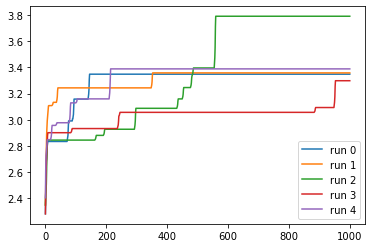

In [6]:
best_finds = []
best_fitnesses = []
for rst in range(5):
    avg_fitness = []
    pool = get_initial_pool()
    for iter in range(1000):
        parents, fitnesses = get_best_k(pool)
        avg_fitness.append(np.mean(fitnesses))
        if iter%100 == 0:
            print(f'Iteration {iter} : {avg_fitness[-1]}')
        children = mate(parents)
        children = mutate(children)
        pool = parents + children

    plt.plot(avg_fitness, label=f'run {rst}')

    best_candidate, best_fittness = get_best_k(pool,1)
    best_candidate = (best_candidate[0])
    result = [[int(idx) for idx in cand] for cand in best_candidate]
    best_finds.append(result)
    best_fitnesses.append(best_fittness)

plt.legend()
best_rst = np.array(best_fitnesses).argmax()
candidate = best_finds[best_rst]
fittness_matrix(candidate)

In [7]:
persona = {}
for i,cand in enumerate(result):
    persona['persona'+str(i)] = {a:idx for a,idx in zip(activities, cand)}

with open('data/personaBasedSchedules/optimized_persona.json', 'w') as f:
    json.dump(persona, f, indent=4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


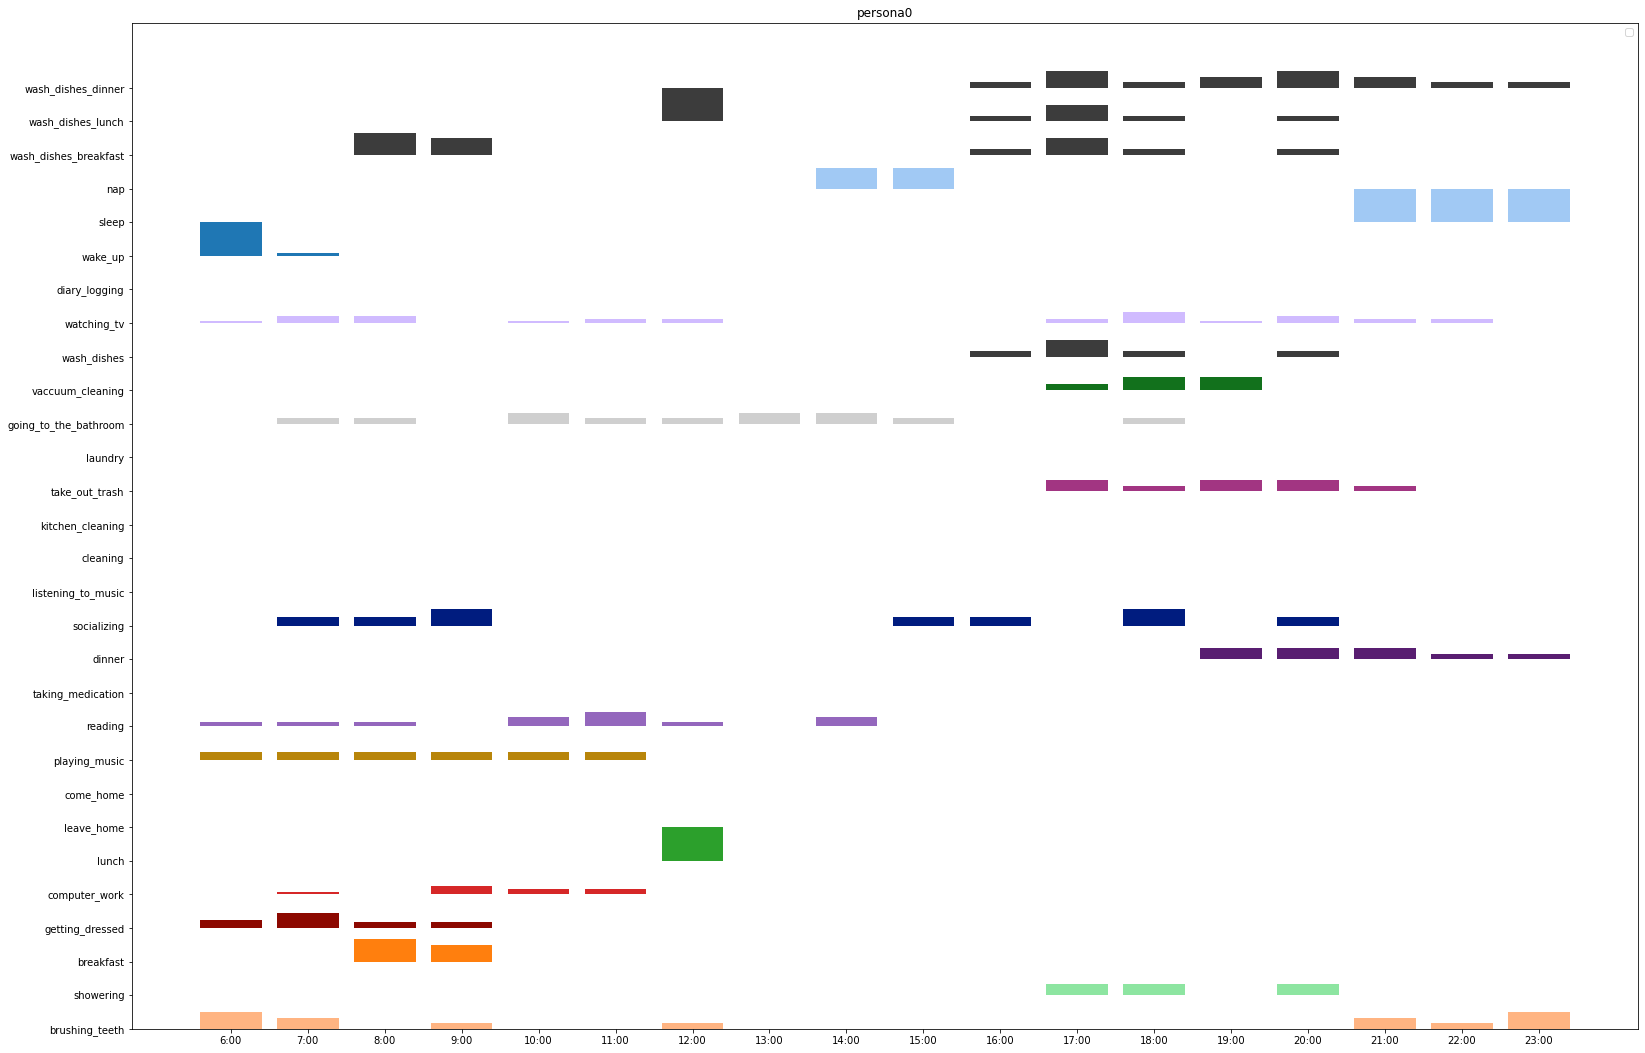

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


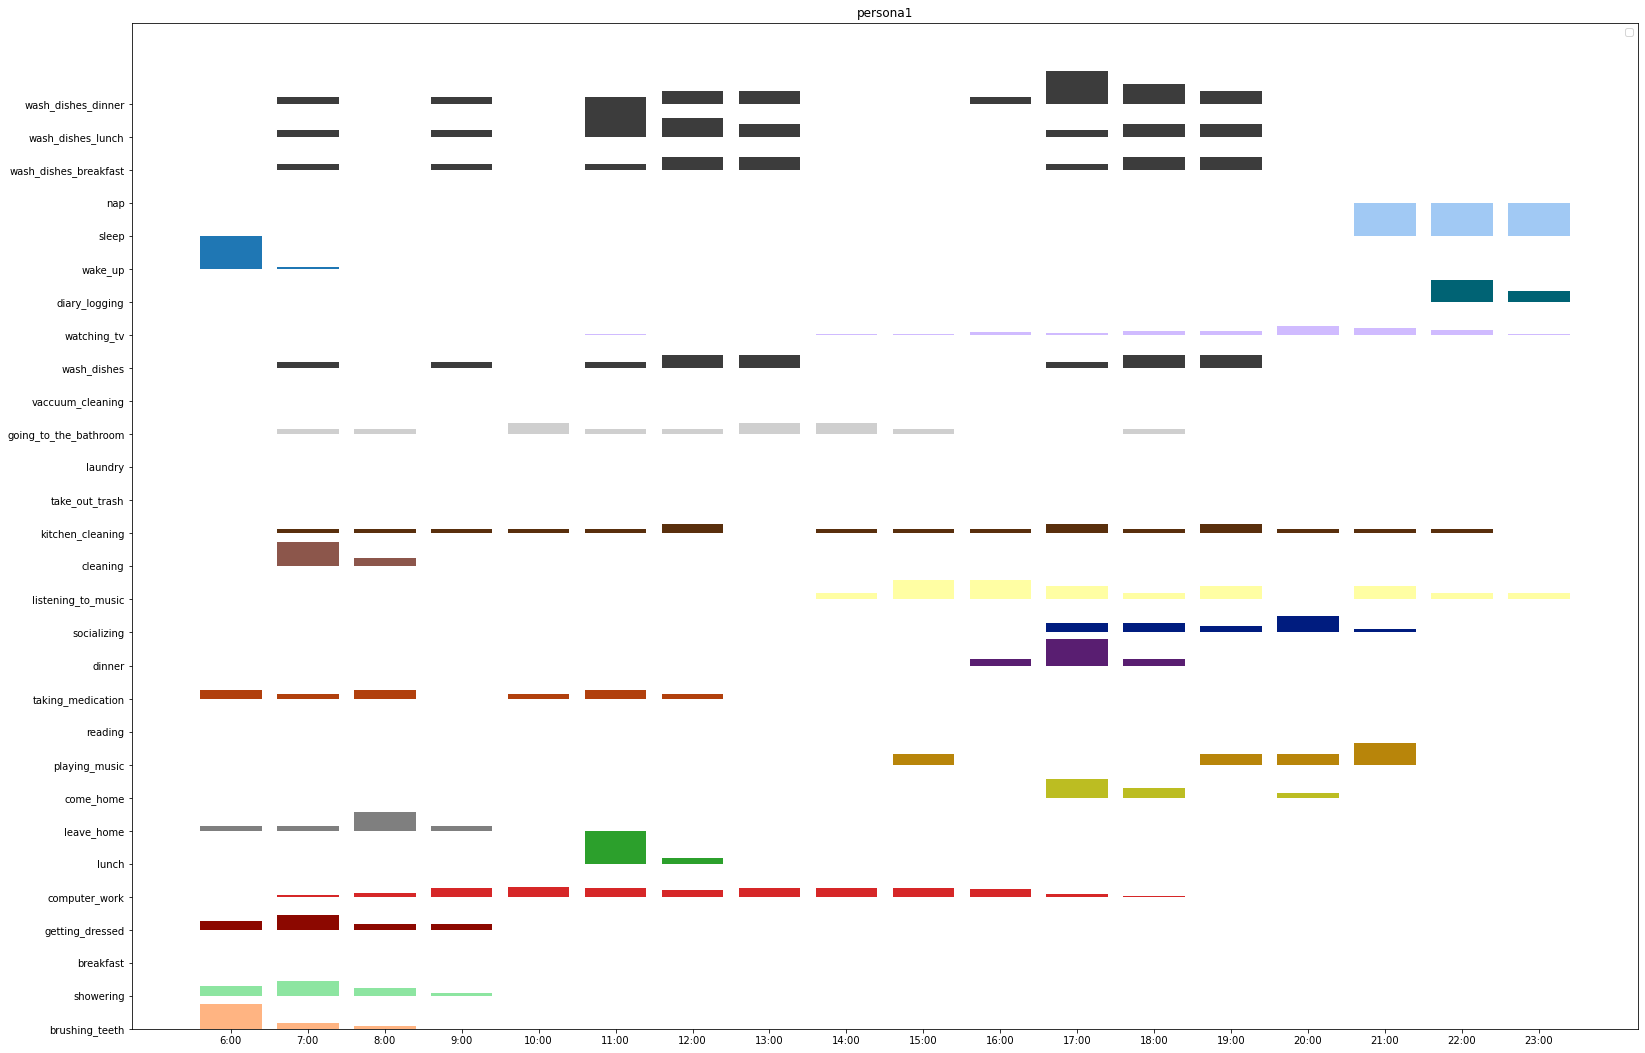

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


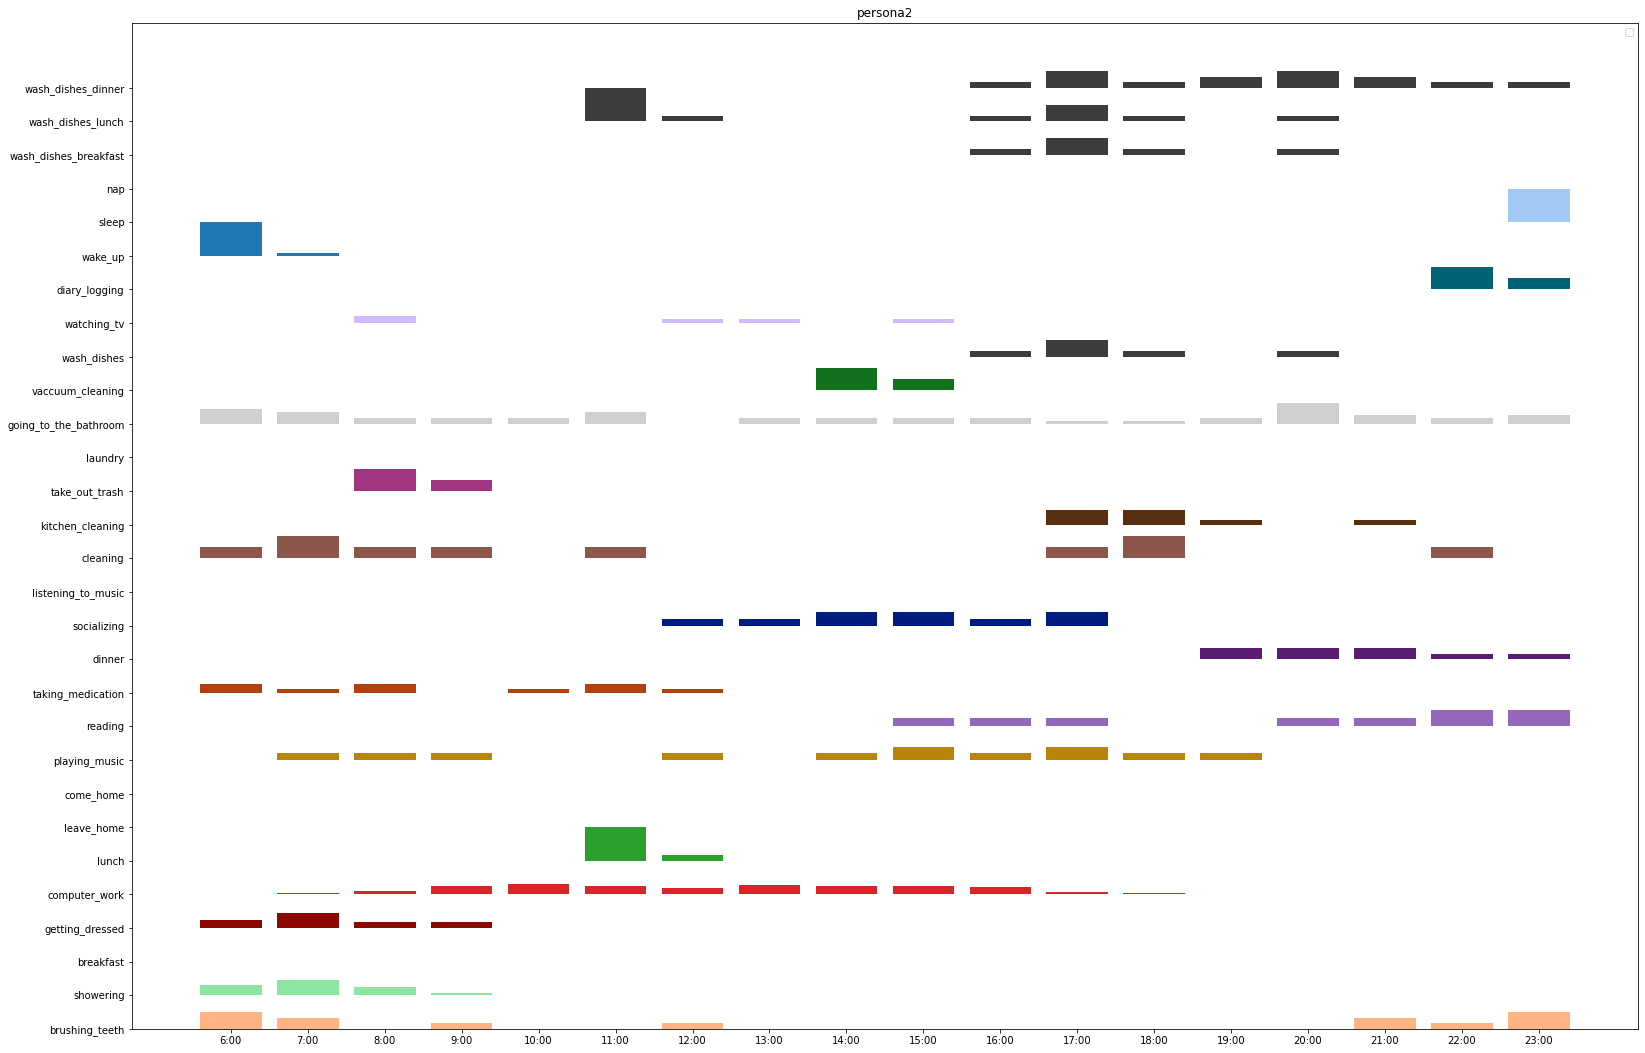

In [1]:
from ScheduleDistributionSampler import ScheduleDistributionSampler

ScheduleDistributionSampler(type='persona0').plot()
ScheduleDistributionSampler(type='persona1').plot()
ScheduleDistributionSampler(type='persona2').plot()

### Optimize for balanced persona

In [ ]:
with open('data/personaBasedSchedules/cluster_histograms.json') as f:
    cluster_histograms = json.load(f)
activities = list(cluster_histograms.keys())

P = 12
N = 40
K = 20

def get_histogram(persona):
    return {act:cluster_histograms[act][choice] for act,choice in zip(activities,persona)}

def get_random_activity_choice(activity_idx):
    return random.choice(np.arange(len(cluster_histograms[activities[activity_idx]])))

def get_random_persona():
    persona = []
    for act in activities:
        activity_options = np.arange(len(cluster_histograms[act]))
        persona.append(random.choice(activity_options))
    return persona

def get_initial_pool():
    return [get_random_persona() for _ in range(N)]

def valid(persona):
    leave_idx = persona[activities.index('leave_home')]
    come_idx = persona[activities.index('come_home')]
    leave_sum = np.sum(cluster_histograms['leave_home'][leave_idx])
    come_sum = np.sum(cluster_histograms['come_home'][come_idx])
    if leave_sum == 0 and come_sum == 0:
        return 1
    if (leave_sum == 0 and come_sum > 0) or (leave_sum > 0 and come_sum == 0):
        return 0
    leave_mean_cumul = np.cumsum(cluster_histograms['leave_home'][leave_idx])
    come_mean_cumul = np.cumsum(cluster_histograms['come_home'][come_idx])
    leave_mean = int(max(np.argwhere(leave_mean_cumul<0.5)))
    come_mean = int(max(np.argwhere(come_mean_cumul<0.5)))
    return float(come_mean > leave_mean)

def fitness(candidate, verbose=False):
    histogram = get_histogram(candidate)
    level = sum([np.array(h) for h in histogram.values()])
    if verbose:
        for h in histogram.items():
            print (h)
        print(list(level))
        print(f"{np.std(level)}/{np.mean(level)}")
    level_fitness = np.mean(level)/np.std(level) * valid(candidate)
    return level_fitness

def get_pool_fitness(pool):
    return np.array([fitness(candidate) for candidate in pool])

def get_best_k(pool, k=K):
    pool_fitness = get_pool_fitness(pool)
    best_k_idx = pool_fitness.argsort()[::-1][:k]
    return [pool[idx] for idx in best_k_idx], pool_fitness[best_k_idx]

def mate(parents):
    random.shuffle(parents)
    children = [candidate[0:floor(len(activities)/2)] for candidate in parents]
    random.shuffle(parents)
    children = [prev+candidate[floor(len(activities)/2):] for candidate, prev in zip(parents,children)]
    return children

def mutate(pool):
    for persona in pool:
        if random.random() < 0.5:
            activity_idx = random.choice(np.arange(len(activities)))
            persona[activity_idx] = get_random_activity_choice(activity_idx)
    return pool
    

In [ ]:
best_finds = set()
best_fitnesses = set()
for rst in range(15):
    avg_fitness = []
    pool = get_initial_pool()
    for iter in range(500):
        parents, fitnesses = get_best_k(pool)
        avg_fitness.append(np.mean(fitnesses))
        if iter%100 == 0:
            print(f'Iteration {iter} : {avg_fitness[-1]}')
        children = mate(parents)
        children = mutate(children)
        pool = parents + children

    plt.plot(avg_fitness, label=f'run {rst}')

    best_candidate, best_fittness = get_best_k(pool,3)
    best_finds.update([(tuple(can), fit) for can,fit in zip(best_candidate, best_fittness)])


In [ ]:
best_finds = list(best_finds)
best_finds.sort(key=lambda x : x[1], reverse=True)
persona = {}
max_candidates = 3
for i,(cand,fit) in enumerate(best_finds):
    if i >= max_candidates:
        break
    persona['balanced'+str(i)] = {a:int(idx) for a,idx in zip(activities, cand)}
    # assert fit == fitness(cand, True)

with open('data/personaBasedSchedules/balanced_persona.json', 'w') as f:
    json.dump(persona, f, indent=4)

In [ ]:
from ScheduleDistributionSampler import ScheduleDistributionSampler

ScheduleDistributionSampler('balanced0').plot()

In [ ]:
ScheduleDistributionSampler('balanced1').plot()

In [ ]:
ScheduleDistributionSampler('balanced2').plot()